In [23]:
import pandas as pd
import numpy as np
from pathlib import Path

import os

import soundfile as sf
from IPython.lib.display import Audio

import librosa
import librosa.display

import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
from torch import nn

In [2]:
root = '/Users/haohe/Desktop/Heart_shenzhen'
audio_data = root + '/audio'
data = root + '/data'

In [3]:
df_train = pd.read_csv(data+'/train.csv')
df_valid = pd.read_csv(data+'/valid_test.csv')

In [4]:
df_valid = df_valid[df_valid['valid']==True]

In [5]:
df_train.shape,df_valid.shape

((394, 16), (149, 17))

In [18]:
df_train.iloc[10]

filename                                            train_0117.wav
orig_filename    648358/Ausculation_Report_Eko_Recording_136363...
id                                                          648358
name                                                           林宝岳
eng_name                                              Lin, Baoyue 
gender                                                         1=男
cul                                                           1=汉族
hometown                                                        温州
age                                                             77
height                                                         170
weight                                                          68
temp                                                            37
bpm                                                             80
tsh                                                           0.73
t4                                                           1

In [6]:
p = audio_data + '/train_0117.wav'

In [7]:
sf.info(p)

/Users/haohe/Desktop/Heart_shenzhen/audio/train_0117.wav
samplerate: 4000 Hz
channels: 1
duration: 30.032 s
format: WAV (Microsoft) [WAV]
subtype: Signed 16 bit PCM [PCM_16]

In [8]:
x,sr = sf.read(p)

In [9]:
x.shape

(120128,)

In [10]:
class AudioDataset(Dataset):
    def __init__(self,df,path,period=30,tfms=None,stats=None,eps=1e-6):
        self.df = df
        self.tfms = tfms
        self.period = period
        self.path = path
        self.stats = stats
        if self.stats:
            self.mean,self.std = stats
        self.eps = eps
        
    def __len__(self):
        return self.df.shape[0]
        
    def __getitem__(self,idx):
        item_p = self.df.iloc[idx].filename
        item_p = self.path + '/' + item_p
        x,sr = sf.read(item_p)
        
        if self.tfms:
            x = self.tfms(x)
        
        else:
            len_x = len(x)
            effective_len = sr * self.period
            if len_x < effective_len:
                new_x = np.zeros(effective_len,dtype=x.dtype)
                start = np.random.randint(effective_len - len_x)
                new_x[start:start + len_x] = x
                x = new_x.astype(np.float32)

            elif len_x > effective_len:
                start = np.random.randint(len_x - effective_len)
                x = x[start:start+effective_len].astype(np.float32)

            else:
                x = x.astype(np.float32)
        
        y = self.df.iloc[idx].tsh,self.df.iloc[idx].t3,self.df.iloc[idx].t4
        if self.stats:
            x = self.normalize(x)
        return (x,(y,item_p))
    
    def normalize(self,x):
        return (x - self.mean) / (self.std + self.eps)

In [24]:
train_ds = AudioDataset(df_train,path=audio_data)
valid_ds = AudioDataset(df_valid,path=audio_data)

In [25]:
train_ds[0]

(array([-0.07366943, -0.06481934, -0.05596924, ...,  0.00747681,
         0.00305176,  0.0020752 ], dtype=float32),
 ((1.12, 4.6, 8.32),
  '/Users/haohe/Desktop/Heart_shenzhen/audio/train_0043.wav'))

In [26]:
x = []
len_x = []
for i in range(len(train_ds)):
    x.append(train_ds[i][0])
    if len(len_x) == 0:
        len_x.append(len(train_ds[i][0]))
    else:
        if len(train_ds[i][0]) not in len_x:
            print(len(train_ds[i][0]),train_ds[i][1][1])
            len_x.append(len(train_ds[i][0]))

In [27]:
len(len_x)

1

In [28]:
np.stack(x).mean(), np.stack(x).std()

(-0.00821876, 0.082204655)

In [56]:
np.stack(x).mean(), np.stack(x).std()

(-0.008218732, 0.08220435)

In [11]:
train_ds = AudioDataset(df_train,path=audio_data,stats=(-0.008218732, 0.08220435))
valid_ds = AudioDataset(df_valid,path=audio_data,stats=(-0.008218732, 0.08220435))

In [12]:
train_ds[0]

(array([ 0.2688904 ,  0.23288053,  0.22100098, ..., -0.13835539,
        -0.10828529, -0.10197428], dtype=float32),
 ((1.12, 4.6, 8.32),
  '/Users/haohe/Desktop/Heart_shenzhen/audio/train_0043.wav'))

In [13]:
valid_ds[0]

(array([0.161232  , 0.13264683, 0.11631244, ..., 0.18016502, 0.18239245,
        0.16605806], dtype=float32),
 ((0.67, 2.7, 13.72),
  '/Users/haohe/Desktop/Heart_shenzhen/audio/devel_0071.wav'))

# Spectrogram

In [16]:
def get_train_transform():
    return A.Compose([
        #A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        #A.Resize(height=512,width=512,p=1.0),
        A.Normalize(p=1.0),
        ToTensorV2(p=1.0),
    ],p=1.0)

def get_valid_transform():
    return A.Compose([
        #A.Resize(height=512,width=512,p=1.0),
        A.Normalize(p=1.0),
        ToTensorV2(p=1.0),
    ],p=1.0)

In [26]:
class MelSpectrogramDataset(Dataset):
    def __init__(self,df,path,period=30,wave_tfms=None,mel_tfms=None,img_tfms=None,stats=None,eps=1e-6):
        self.df = df
        self.path = path
        self.period = period
        self.wave_tfms,self.mel_tfms,self.img_tfms = wave_tfms,mel_tfms,img_tfms
        self.stats = stats
        if self.stats:
            self.mean, self.std = self.stats
        self.eps = eps
    
    def __getitem__(self,idx):
        item_p = self.df.iloc[idx].filename
        item_p = self.path + '/' + item_p
        x,sr = sf.read(item_p)
        
        if self.wave_tfms:
            x = self.wave_tfms(x)
        
        else:
            len_x = len(x)
            effective_len = sr * self.period
            if len_x < effective_len:
                new_x = np.zeros(effective_len,dtype=x.dtype)
                start = np.random.randint(effective_len - len_x)
                new_x[start:start + len_x] = x
                x = new_x.astype(np.float32)

            elif len_x > effective_len:
                start = np.random.randint(len_x - effective_len)
                x = x[start:start+effective_len].astype(np.float32)

            else:
                x = x.astype(np.float32)
        
        melspec = librosa.feature.melspectrogram(x,sr=sr,n_mels=128)
        melspec = librosa.power_to_db(melspec).astype(np.float32)
        
        if self.mel_tfms:
            melspec = self.mel_tfms(melspec)
        
        image = self.bw_to_color(melspec)
        if self.img_tfms:
            aug = self.img_tfms(
                image = image,
            )
            image = aug['image']
        y = self.df.iloc[idx].tsh,self.df.iloc[idx].t3,self.df.iloc[idx].t4
#         if self.stats:
#             x = self.normalize(x)
        return (image,(y,item_p))
    
    def bw_to_color(self,x):
        x = np.stack([x,x,x],axis=-1)
        mean = x.mean()
        xstd = x.std()
        x = (x - mean) / (xstd + self.eps)
        _min, _max = x.min(),x.max()
        if (_max - _min) > self.eps:
            x[x < _min] = _min
            x[x > _max] = _max
            x = 255 * (x - _min) / (_max - _min)
            x = x.astype(np.uint8)
        else:
            x = np.zeros_like(x,dtype=np.uint8)
        return x
        
    
    def __len__(self):
        return self.df.shape[0]

In [27]:
train_ds = MelSpectrogramDataset(df_train,audio_data,img_tfms=get_train_transform())

In [28]:
train_ds[0]

(tensor([[[ 1.3242,  1.2557,  1.4098,  ...,  0.8618,  1.3070,  1.3755],
          [ 1.4954,  1.5468,  1.9749,  ...,  1.6667,  2.0263,  1.7694],
          [ 1.2385,  1.5982,  2.0777,  ...,  1.6838,  2.1462,  1.9235],
          ...,
          [-0.9192, -1.0904, -1.5357,  ..., -1.5357, -1.5357, -1.6042],
          [-0.9020, -1.0562, -1.4500,  ..., -1.6213, -1.6898, -1.6042],
          [-0.8678, -1.0562, -1.5185,  ..., -1.5870, -1.6898, -1.7925]],
 
         [[ 1.4832,  1.4132,  1.5707,  ...,  1.0105,  1.4657,  1.5357],
          [ 1.6583,  1.7108,  2.1485,  ...,  1.8333,  2.2010,  1.9384],
          [ 1.3957,  1.7633,  2.2535,  ...,  1.8508,  2.3235,  2.0959],
          ...,
          [-0.8102, -0.9853, -1.4405,  ..., -1.4405, -1.4405, -1.5105],
          [-0.7927, -0.9503, -1.3529,  ..., -1.5280, -1.5980, -1.5105],
          [-0.7577, -0.9503, -1.4230,  ..., -1.4930, -1.5980, -1.7031]],
 
         [[ 1.6988,  1.6291,  1.7860,  ...,  1.2282,  1.6814,  1.7511],
          [ 1.8731,  1.9254,

In [29]:
def denormalize(x:torch.tensor):
    mean=torch.tensor([0.485, 0.456, 0.406])
    std=torch.tensor([0.229, 0.224, 0.225])
    return x * std[...,None,None] + mean[...,None,None]

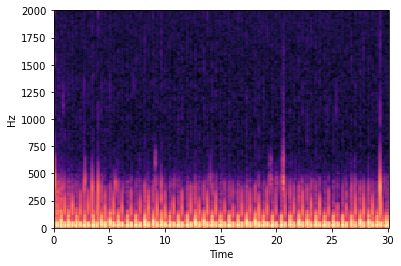

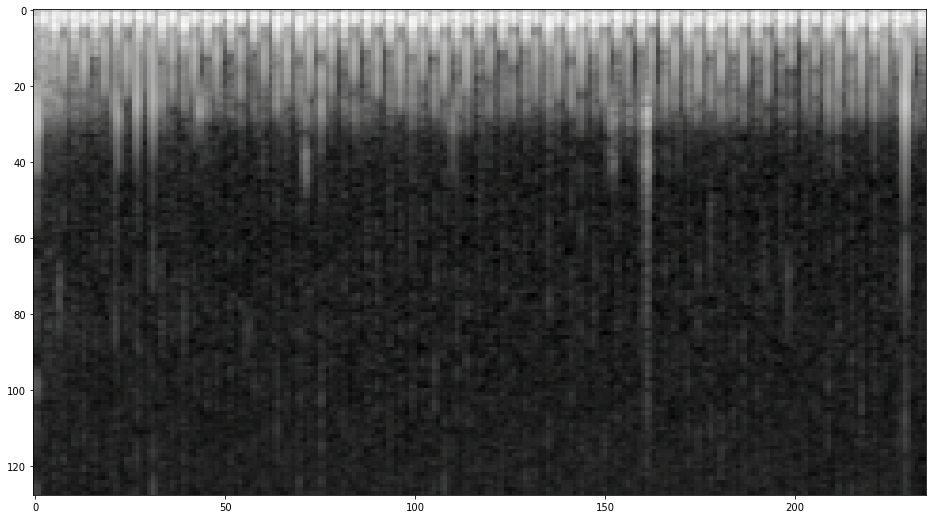

In [31]:
image,target = train_ds[0]
image = denormalize(image)

image = image.permute(1,2,0).numpy()

librosa.display.specshow(image[:,:,0],sr=sr,x_axis='time',y_axis='hz')
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(image)
